<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Neural Networks (NN) - MLP Modeling 
</p>

In [1]:
# -----------------------------------------------------------------------------------
# Libraries for data manipulation, visualization, and modeling
# -----------------------------------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.models import Sequential
from keras.layers import (
    Dense, 
    Input, 
    BatchNormalization, 
    Dropout, 
    LeakyReLU
)
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import (
    mean_squared_error, 
    r2_score, 
    mean_absolute_percentage_error, 
    median_absolute_error
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split

# Set seeds for reproducibility
np.random.seed(50)
tf.random.set_seed(50)

In [2]:
# -----------------------------------------------------------------------------------
# Load dataset and display basic info
# -----------------------------------------------------------------------------------

# Path to your dataset
dataset_path = '../../all_data_files/cleaned_dataset_per_device.csv'

# Load the dataset
try:
    df = pd.read_csv(dataset_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"File not found at the specified path: {dataset_path}")
    import sys
    sys.exit()

# Display dataset information
print("\nDataset Information:")
df.info()

# Preview the first five rows
print("\nFirst Five Rows of the Dataset:")
display(df.head())

Dataset loaded successfully.

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739089 entries, 0 to 739088
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   time         739089 non-null  object 
 1   device_id    739089 non-null  object 
 2   co2          739089 non-null  float64
 3   humidity     739089 non-null  float64
 4   pm25         739089 non-null  float64
 5   pressure     739089 non-null  float64
 6   temperature  739089 non-null  float64
 7   rssi         739089 non-null  float64
 8   snr          739089 non-null  float64
 9   SF           739089 non-null  int64  
 10  frequency    739089 non-null  float64
 11  f_count      739089 non-null  float64
 12  p_count      739089 non-null  float64
 13  toa          739089 non-null  float64
 14  distance     739089 non-null  int64  
 15  c_walls      739089 non-null  int64  
 16  w_walls      739089 non-null  int64  
 17  exp_pl       739

,time,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl,n_power,esp
0,2024-09-26 11:00:52.542462+00:00,ED3,633.0,54.22,0.58,300.41,23.85,-71.0,12.2,10,867.9,94.0,104.0,0.452608,18,1,2,88.4,-83.454107,-71.254107
1,2024-09-26 11:01:52.383162+00:00,ED3,645.0,54.18,0.32,300.48,23.87,-74.0,12.5,9,867.7,95.0,105.0,0.246784,18,1,2,91.4,-86.737602,-74.237602
2,2024-09-26 11:02:52.425491+00:00,ED3,648.0,54.23,0.58,300.50,23.88,-76.0,12.2,9,867.1,96.0,106.0,0.246784,18,1,2,93.4,-88.454107,-76.254107
3,2024-09-26 11:02:52.426016+00:00,ED3,648.0,54.23,0.58,300.50,23.88,-76.0,12.2,9,867.1,96.0,106.0,0.246784,18,1,2,93.4,-88.454107,-76.254107
4,2024-09-26 11:03:52.481201+00:00,ED3,645.0,54.25,0.33,300.50,23.90,-76.0,13.2,9,868.3,97.0,107.0,0.246784,18,1,2,93.4,-89.403045,-76.203045


In [3]:
# -----------------------------------------------------------------------------------
#  Extract necessary columns, perform train-test split, and scale features
# -----------------------------------------------------------------------------------

# Define feature columns and target
feature_columns = [
    'distance', 
    'frequency', 
    'c_walls', 
    'w_walls', 
    'co2', 
    'humidity', 
    'pm25', 
    'pressure', 
    'temperature', 
    'snr'
]
target_column = 'exp_pl'

# Check for missing columns
missing_columns = set(feature_columns + [target_column]) - set(df.columns)
if missing_columns:
    raise ValueError(f"The following required columns are missing in the dataset: {missing_columns}")

# Extract features (X) and target (y)
all_features = df[feature_columns].values
PL_all = df[target_column].values

# Train-test split (80-20)
X_train_all, X_test_all, PL_train_all, PL_test_all = train_test_split(
    all_features, 
    PL_all, 
    test_size=0.2, 
    random_state=50
)

# Feature scaling
scaler = StandardScaler()
X_train_all_scaled = scaler.fit_transform(X_train_all)
X_test_all_scaled = scaler.transform(X_test_all)

print("Feature scaling completed.")

Feature scaling completed.


In [4]:
# -----------------------------------------------------------------------------------
# Flexible model creation function
# -----------------------------------------------------------------------------------

def create_ann_model(layer_units, input_dim, 
                     l2_reg=0.001, 
                     dropout_rate=0.3, 
                     negative_slope=0.1):
    """
    Creates an ANN model for regression with configurable architecture and 
    hyperparameters like L2 regularization, dropout, and LeakyReLU slope.
    
    Arguments:
        layer_units    : list of integers (e.g., [64, 32]) specifying 
                         the number of neurons in each hidden layer
        input_dim      : int, dimension of the input layer
        l2_reg         : float, L2 regularization factor
        dropout_rate   : float, dropout rate
        negative_slope : float, negative slope for LeakyReLU
    Returns:
        model          : Compiled Keras Sequential model
    """
    model = Sequential()
    model.add(Input(shape=(input_dim,)))  # Explicit input layer

    # Add hidden layers based on the list of units
    for units in layer_units:
        model.add(Dense(units, kernel_regularizer=l2(l2_reg)))
        model.add(LeakyReLU(negative_slope=negative_slope))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    # Output layer for regression
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    return model

In [ ]:
# -----------------------------------------------------------------------------------
# Train the 9 candidate architectures, store histories & predictions
# -----------------------------------------------------------------------------------

# Define our 9 architectures:
architectures = [
    # 2-Layer Models
    {'name': 'A1', 'units': [5, 2]}, 
    {'name': 'A2', 'units': [10, 5]}, 
    {'name': 'A3', 'units': [16, 10]}, 
    {'name': 'A4', 'units': [24, 15]}, 
    {'name': 'A5', 'units': [32, 20]}, 
    
    # 3-Layer Models
    {'name': 'B1', 'units': [5, 2, 2]}, 
    {'name': 'B2', 'units': [10, 5, 3]}, 
    {'name': 'B3', 'units': [16, 10, 5]}, 
    {'name': 'B4', 'units': [24, 15, 5]},
    {'name': 'B5', 'units': [32, 20, 5]}, 
    
]

# Prepare containers for final results and for plotting
model_results = []
arch_histories = {}       # to store each model's training history
arch_predictions = {}     # to store each model's predictions on the test set

# Define callbacks (we'll reuse these for each model)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=0
)

for arch in architectures:
    print(f"\nTraining Architecture: {arch['name']} with layers {arch['units']}")
    
    # Create a fresh model
    model = create_ann_model(
        layer_units=arch['units'], 
        input_dim=X_train_all_scaled.shape[1],
        l2_reg=0.001,
        dropout_rate=0.3,
        negative_slope=0.1
    )
    
    # Train the model
    history = model.fit(
        X_train_all_scaled,
        PL_train_all,
        validation_split=0.2,
        epochs=3000,
        batch_size=128,
        verbose=0,  # set to 1 or 2 if you want more logs
        callbacks=[early_stop, reduce_lr]
    )
    
    # Store the training history so we can plot later
    arch_histories[arch['name']] = history
    
    # Evaluate on training data
    train_loss, train_mae = model.evaluate(X_train_all_scaled, PL_train_all, verbose=0)
    
    # Evaluate on test data
    test_loss, test_mae = model.evaluate(X_test_all_scaled, PL_test_all, verbose=0)
    
    # Predict on the test set
    PL_pred = model.predict(X_test_all_scaled).flatten()
    
    # Store predictions for later (Actual vs. Predicted plot)
    arch_predictions[arch['name']] = PL_pred
    
    # Additional metrics
    rmse_test = np.sqrt(mean_squared_error(PL_test_all, PL_pred))
    r2_test = r2_score(PL_test_all, PL_pred)
    mape_test = mean_absolute_percentage_error(PL_test_all, PL_pred) * 100
    median_ae_test = median_absolute_error(PL_test_all, PL_pred)
    
    # Store the results in a list
    model_results.append({
        'Architecture': arch['name'],
        'Hidden Layers': str(arch['units']),
        'Train MSE': train_loss,
        'Train MAE': train_mae,
        'Test MSE': test_loss,
        'Test MAE': test_mae,
        'Test RMSE': rmse_test,
        'R2 Score': r2_test,
        'Test MAPE (%)': mape_test,
        'Test Median AE': median_ae_test
    })
    
    print(f"Completed {arch['name']} -> Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}, R2: {r2_test:.4f}")

# Convert the list of dicts to a DataFrame
model_results_df = pd.DataFrame(model_results)
print("\nAll architectures trained. Here is the summary:")
display(model_results_df)


Training Architecture: A1 with layers [5, 2]
4620/4620 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Completed A1 -> Test MSE: 50.8476, Test MAE: 5.5568, R2: 0.8575

Training Architecture: A2 with layers [10, 5]
4620/4620 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Completed A2 -> Test MSE: 34.9643, Test MAE: 4.4768, R2: 0.9020

Training Architecture: A3 with layers [15, 10]
4620/4620 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Completed A3 -> Test MSE: 29.5697, Test MAE: 3.9933, R2: 0.9172

Training Architecture: A4 with layers [20, 15]
4620/4620 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Completed A4 -> Test MSE: 27.6835, Test MAE: 3.9050, R2: 0.9226

Training Architecture: B1 with layers [5, 2, 2]
4620/4620 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
Completed B1 -> Test MSE: 81.7403, Test MAE: 6.7183, R2: 0.7708

Training Architecture: B2 with layers [10, 5, 3]
4620/4620 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Completed B2 -> Test MSE: 43.5687, Test MAE: 5.1456, R2: 0.8779

Training Architecture: B3 with layers [15, 10, 5]
4620/4620 ━━━━━━━━━

,Architecture,Hidden Layers,Train MSE,Train MAE,Test MSE,Test MAE,Test RMSE,R2 Score,Test MAPE (%),Test Median AE
0,A1,"[5, 2]",50.521999,5.541049,50.847561,5.556788,7.129785,0.857468,6.417424,4.770306
1,A2,"[10, 5]",34.788155,4.468377,34.964279,4.476832,5.910880,0.902037,5.087684,3.657730
2,A3,"[15, 10]",29.409361,3.987842,29.569670,3.993260,5.433973,0.917207,4.414757,3.098853
3,A4,"[20, 15]",27.536808,3.897174,27.683468,3.905010,5.254634,0.922582,4.393434,3.088647
4,B1,"[5, 2, 2]",81.049492,6.695407,81.740326,6.718274,9.040293,0.770848,7.533151,5.375810
5,B2,"[10, 5, 3]",43.289997,5.129709,43.568741,5.145569,6.598027,0.877936,5.974250,4.403456
6,B3,"[15, 10, 5]",31.620253,4.258708,31.811977,4.270208,5.634507,0.910983,4.862420,3.534060
7,B4,"[20, 15, 5]",29.550930,4.110365,29.695848,4.120654,5.441589,0.916975,4.674751,3.403787
8,C1,"[5, 3, 2, 2]",67.893196,6.439962,68.409225,6.460888,8.269909,0.808239,7.534635,5.483576
9,C2,"[10, 5, 3, 2]",58.705650,6.004779,59.156200,6.020292,7.689341,0.834218,6.894142,5.174394


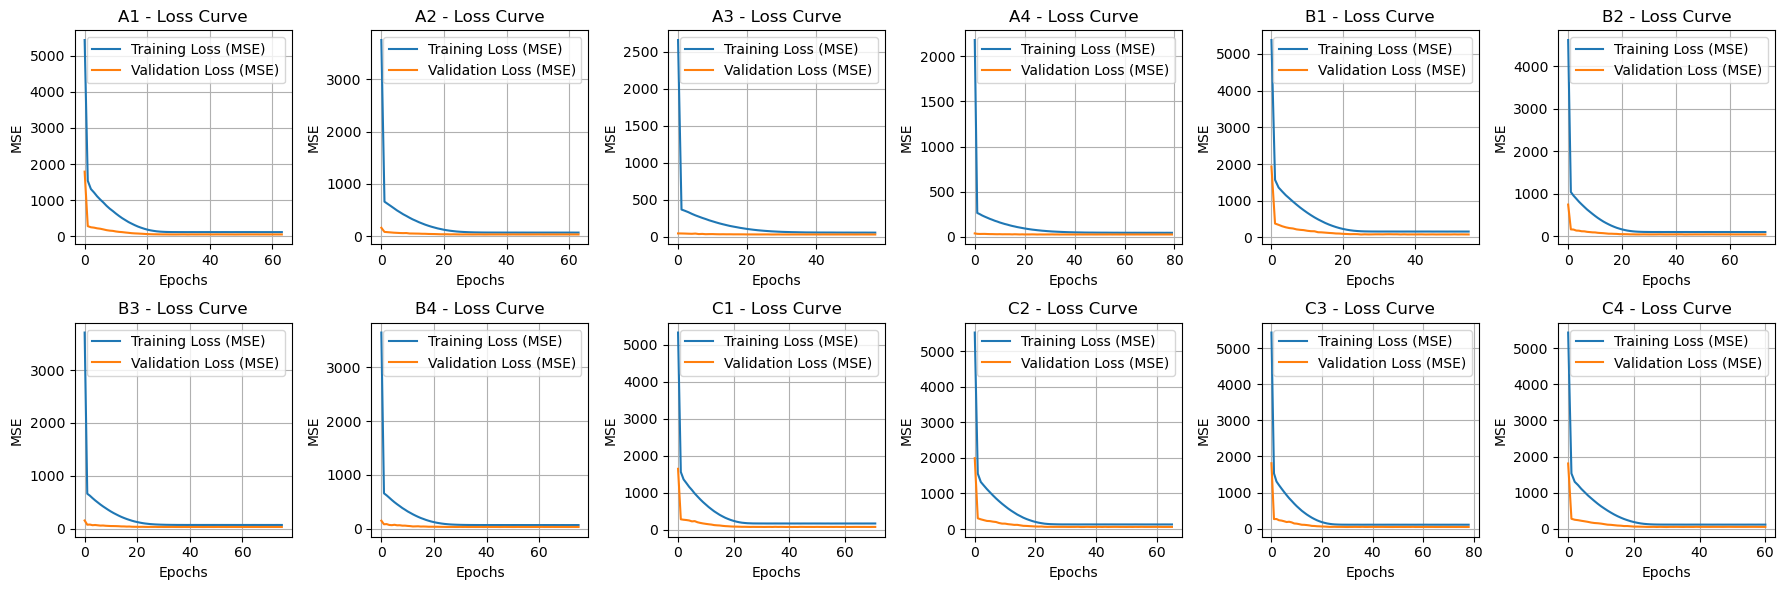

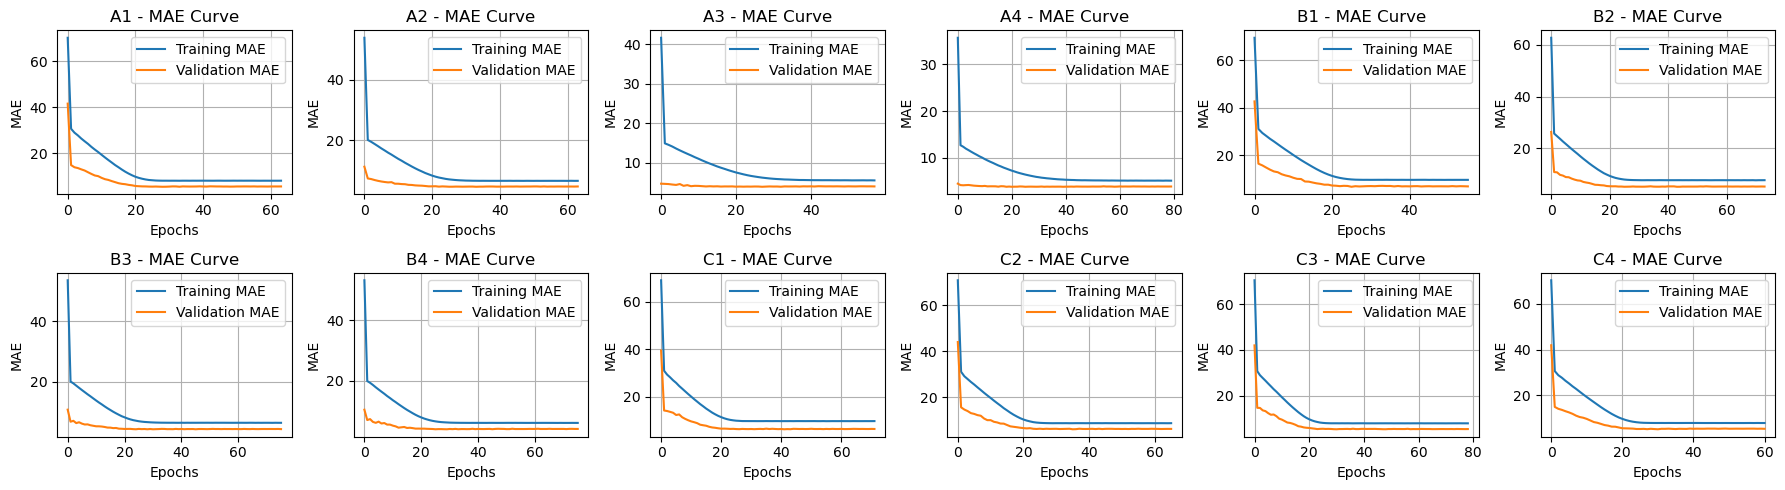

In [ ]:
# -----------------------------------------------------------------------------------
# Visualize training history for each architecture
# -----------------------------------------------------------------------------------

# We'll create a 3x3 grid of subplots (one for each model).
fig, axes = plt.subplots(2, 6, figsize=(18, 5))
axes = axes.flatten()  # turn into a 1D array for easy iteration

for i, (arch_name, hist_obj) in enumerate(arch_histories.items()):
    # Each arch_name is e.g., 'A1', 'A2', ... 'C3'
    # hist_obj is the History object returned by model.fit(...)
    
    # Retrieve metrics from history
    train_loss = hist_obj.history['loss']
    val_loss = hist_obj.history['val_loss']
    train_mae = hist_obj.history.get('mae', [])      # 'mae' if tracked
    val_mae = hist_obj.history.get('val_mae', [])    # 'val_mae' if tracked
    
    ax = axes[i]
    ax.set_title(f"{arch_name} - Loss Curve")
    ax.plot(train_loss, label='Training Loss (MSE)')
    ax.plot(val_loss, label='Validation Loss (MSE)')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('MSE')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

# If you also want to plot MAE subplots, you could either expand the existing 3x3 
# or create another figure. For brevity, here's a separate figure for MAE:

fig, axes = plt.subplots(2, 6, figsize=(18, 5))
axes = axes.flatten()

for i, (arch_name, hist_obj) in enumerate(arch_histories.items()):
    train_mae = hist_obj.history.get('mae', None)
    val_mae = hist_obj.history.get('val_mae', None)
    
    ax = axes[i]
    ax.set_title(f"{arch_name} - MAE Curve")
    if train_mae is not None and val_mae is not None:
        ax.plot(train_mae, label='Training MAE')
        ax.plot(val_mae, label='Validation MAE')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('MAE')
        ax.grid(True)
        ax.legend()
    else:
        ax.text(0.5, 0.5, "MAE not tracked", ha='center', va='center')
        ax.set_axis_off()

plt.tight_layout()
plt.show()

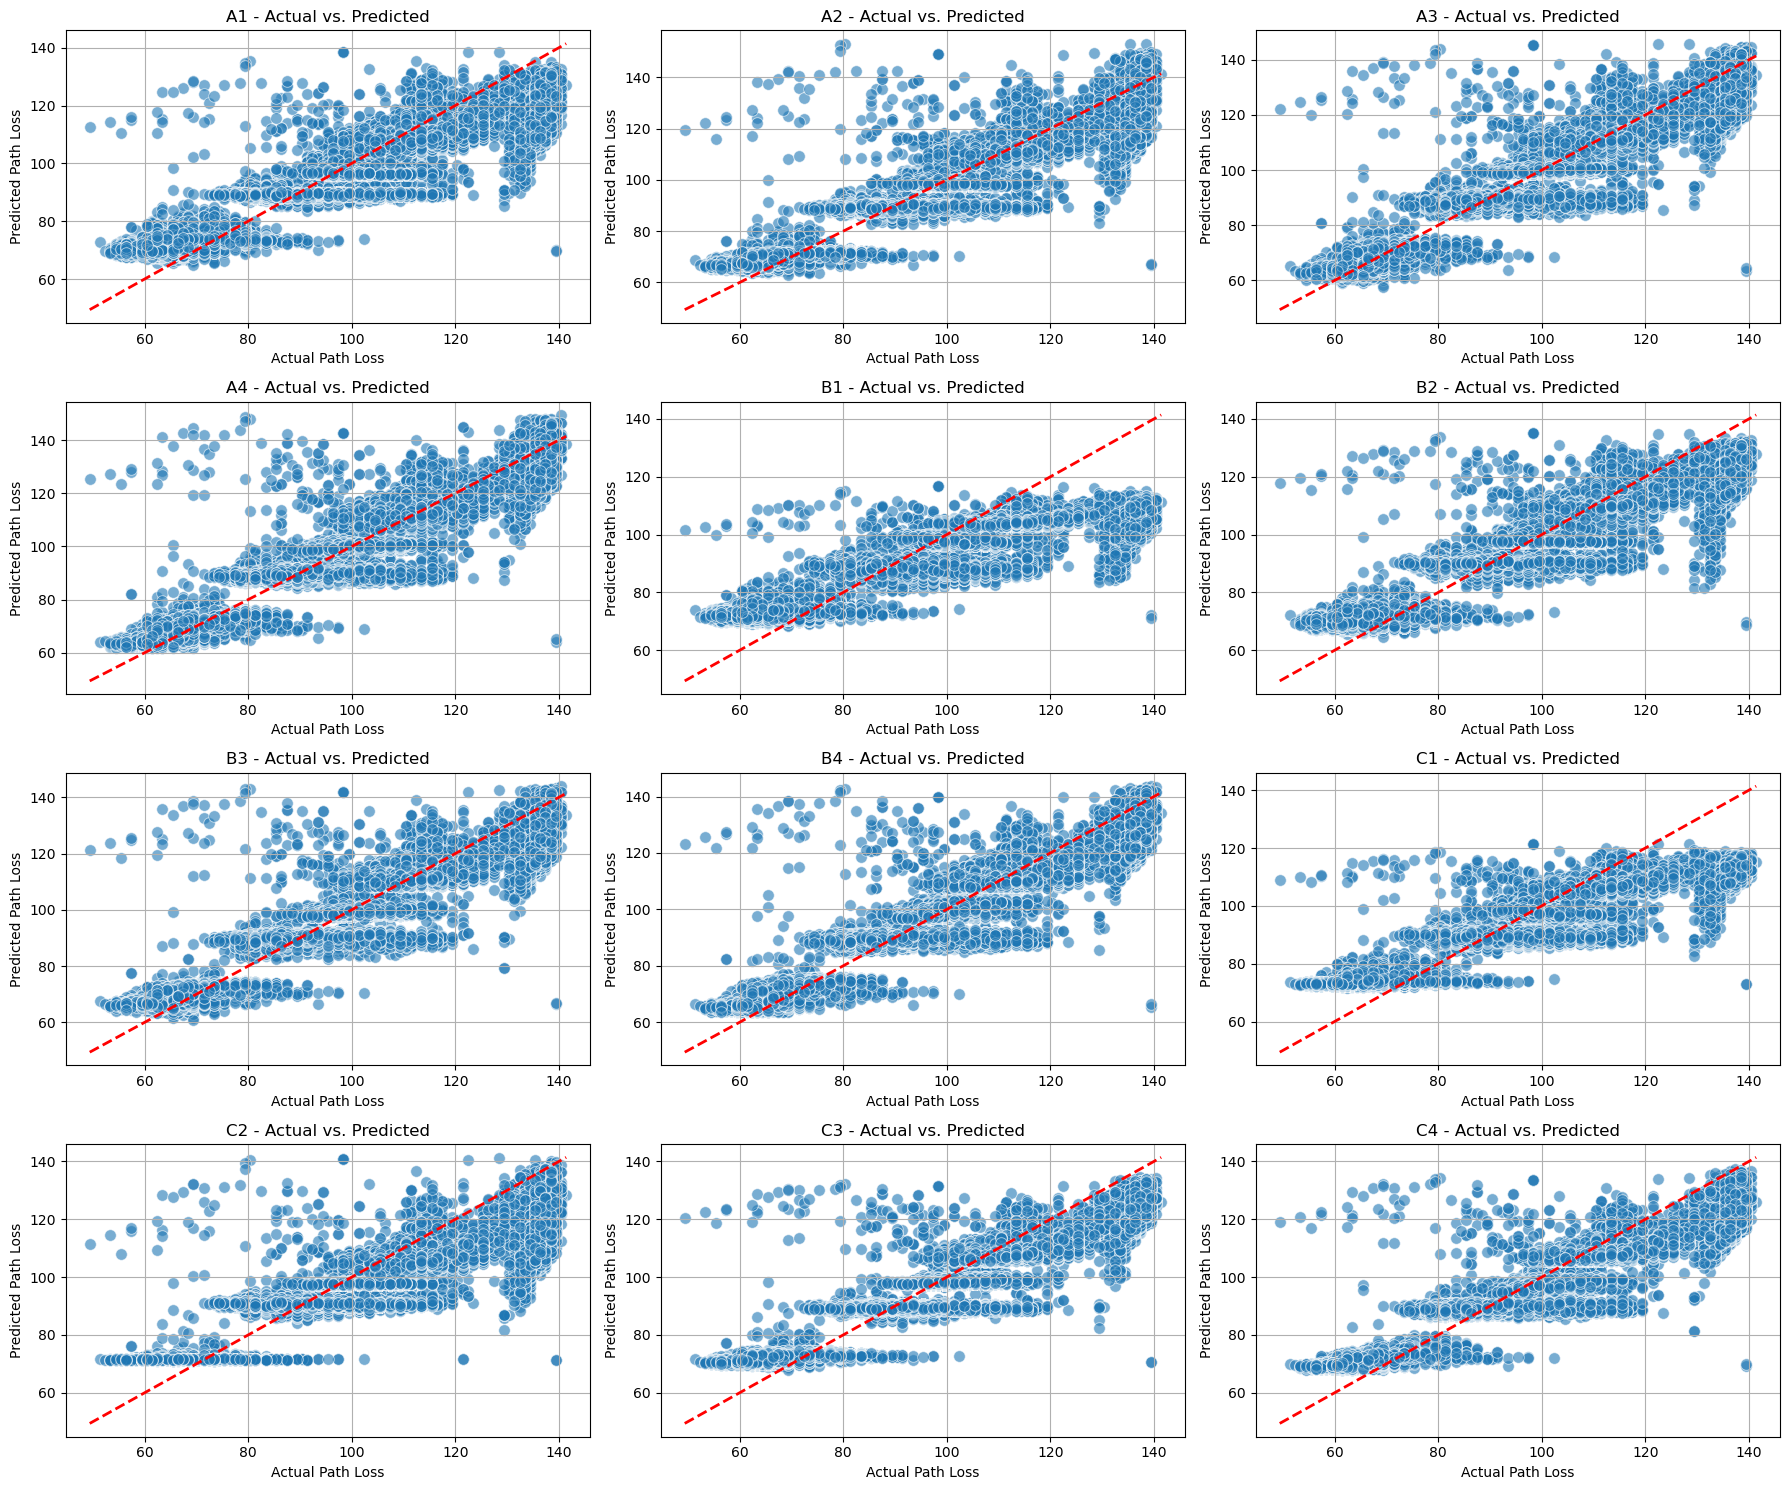

In [9]:
# -----------------------------------------------------------------------------------
# Actual vs. Predicted scatter plots for each architecture
# -----------------------------------------------------------------------------------

fig, axes = plt.subplots(4, 3, figsize=(18, 15))
axes = axes.flatten()

for i, (arch_name, preds) in enumerate(arch_predictions.items()):
    ax = axes[i]
    sns.scatterplot(
        x=PL_test_all, y=preds, 
        alpha=0.6, edgecolor='w', s=70, 
        ax=ax
    )
    ax.plot(
        [PL_test_all.min(), PL_test_all.max()], 
        [PL_test_all.min(), PL_test_all.max()], 
        'r--', lw=2
    )
    ax.set_xlabel('Actual Path Loss')
    ax.set_ylabel('Predicted Path Loss')
    ax.set_title(f'{arch_name} - Actual vs. Predicted')
    ax.grid(True)

plt.tight_layout()
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Cross-Validation
</p>

In [ ]:
# -----------------------------------------------------------------------------------
# K-Fold Cross-Validation for each architecture
# -----------------------------------------------------------------------------------

kfold_results = []

# K-Fold settings
n_splits = 5  # using 5 for demonstration; set to 5 or 10 as you wish
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Iterate over each architecture
for arch in architectures:
    print(f"\nPerforming {n_splits}-Fold CV for Architecture: {arch['name']}")
    fold_num = 1
    fold_metrics = []
    
    for train_idx, val_idx in kf.split(X_train_all_scaled):
        print(f"  Fold {fold_num}/{n_splits}...")

        # Split data
        X_train_fold, X_val_fold = X_train_all_scaled[train_idx], X_train_all_scaled[val_idx]
        y_train_fold, y_val_fold = PL_train_all[train_idx], PL_train_all[val_idx]
        
        # Build model
        model_cv = create_ann_model(
            layer_units=arch['units'], 
            input_dim=X_train_all_scaled.shape[1],
            l2_reg=0.001,
            dropout_rate=0.3,
            negative_slope=0.1
        )
        
        # Define callbacks
        early_stop_cv = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
        
        reduce_lr_cv = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=0
        )
        
        # Train
        history_cv = model_cv.fit(
            X_train_fold,
            y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=100,    # reduce for demonstration
            batch_size=128,
            verbose=0,
            callbacks=[early_stop_cv, reduce_lr_cv]
        )
        
        # Evaluate on the (full) test set
        test_loss_cv, test_mae_cv = model_cv.evaluate(X_test_all_scaled, PL_test_all, verbose=0)
        pl_pred_cv = model_cv.predict(X_test_all_scaled).flatten()
        
        # Compute metrics
        rmse_cv = np.sqrt(mean_squared_error(PL_test_all, pl_pred_cv))
        r2_cv = r2_score(PL_test_all, pl_pred_cv)
        mape_cv = mean_absolute_percentage_error(PL_test_all, pl_pred_cv) * 100
        median_ae_cv = median_absolute_error(PL_test_all, pl_pred_cv)
        
        fold_metrics.append({
            'Fold': fold_num,
            'Test MSE': test_loss_cv,
            'Test MAE': test_mae_cv,
            'Test RMSE': rmse_cv,
            'R2 Score': r2_cv,
            'Test MAPE (%)': mape_cv,
            'Test Median AE': median_ae_cv
        })
        
        print(f"    Fold {fold_num} Metrics - Test MSE: {test_loss_cv:.4f} | Test RMSE: {rmse_cv:.4f} | R²: {r2_cv:.4f} | MAPE: {mape_cv:.2f}%")
        fold_num += 1
    
    # After k-fold loop, summarize
    arch_cv_df = pd.DataFrame(fold_metrics)
    arch_cv_mean = arch_cv_df.mean(numeric_only=True)
    arch_cv_std = arch_cv_df.std(numeric_only=True)
    
    kfold_results.append({
        'Architecture': arch['name'],
        'Hidden Layers': str(arch['units']),
        'Mean Test MSE': arch_cv_mean['Test MSE'],
        'Std Test MSE': arch_cv_std['Test MSE'],
        'Mean Test MAE': arch_cv_mean['Test MAE'],
        'Std Test MAE': arch_cv_std['Test MAE'],
        'Mean RMSE': arch_cv_mean['Test RMSE'],
        'Std RMSE': arch_cv_std['Test RMSE'],
        'Mean R2': arch_cv_mean['R2 Score'],
        'Std R2': arch_cv_std['R2 Score'],
        'Mean MAPE (%)': arch_cv_mean['Test MAPE (%)'],
        'Std MAPE (%)': arch_cv_std['Test MAPE (%)'],
        'Mean MedAE': arch_cv_mean['Test Median AE'],
        'Std MedAE': arch_cv_std['Test Median AE']
    })

# Display aggregated K-Fold results for all architectures
kfold_results_df = pd.DataFrame(kfold_results)
print("\nK-Fold Cross-Validation Summary for All Architectures:")
display(kfold_results_df)